In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import solve_ivp, odeint
import arviz as az
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from scipy import stats
import matplotlib as mpl
import time
import theano.tensor as tt
from theano.compile.ops import as_op
from collections import OrderedDict 


import warnings
warnings.filterwarnings("ignore")




models 2,3,4
time-it methods using a decorator
cull imports

mybinder (online git repos for notebooks)
generate requirements.txt

In [2]:
path_to_data = "filtered_data_csv.csv"
data = pd.read_csv(path_to_data)
data.head()


,Day,G1_avg,G1_sd,G2_avg,G2_sd,G3_avg,G3_sd,G4_avg,G4_sd,G5_avg,G5_sd,G6_avg,G6_sd
0,7,51.786507,20.212286,31.930893,16.927490,48.806049,19.286955,43.664264,19.417161,30.988742,17.752230,44.409795,13.040341
1,14,66.185535,27.352276,53.804666,21.294581,69.038249,35.959695,46.313592,27.260107,34.640653,25.398323,60.142226,16.147825
2,23,100.841313,48.551059,67.105632,29.538706,126.046100,42.178934,85.785176,68.526077,61.905680,33.892752,135.849364,62.744238
3,29,205.291993,85.584746,141.023314,53.179914,241.478202,111.850683,251.086596,140.093869,134.994293,65.107710,207.222552,91.554513
4,34,334.876240,106.083280,225.843888,92.229404,393.011416,100.606232,443.482321,223.956685,257.324806,123.482982,303.385114,117.382875


In [3]:
data_array = data.to_numpy()
days = data_array[:,0]
tumor_sizes = data_array[:,1::2].T
tumor_sigmas = data_array[:,2::2].T
T0 = tumor_sizes[:,0]

print(tumor_sizes.shape)
print(T0.shape)




(6, 19)
(6,)


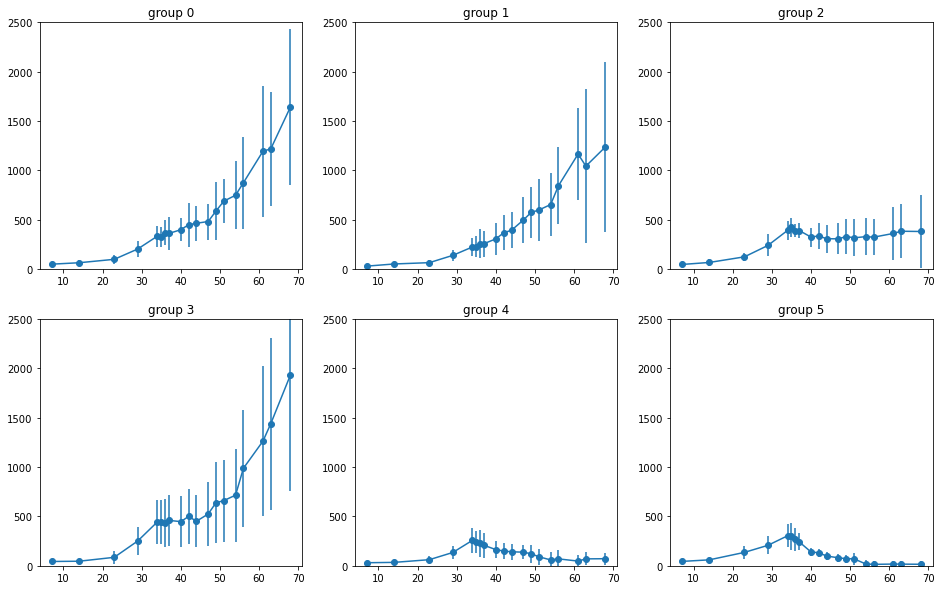

In [4]:
plt.figure(figsize=(16,10))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.ylim(0,2500)
    plt.scatter(days, tumor_sizes[ii,:])
    plt.errorbar(days, tumor_sizes[ii,:], tumor_sigmas[ii,:])
    plt.title("group {}".format(ii))
plt.show()

In [5]:

class growth_model(object):
    def simulate(self, fit_params, times=days):      
        return self.rhs(times, fit_params)
        
    def rhs(self, times, fit_params):
        return np.zeros((6,))
    
    def get_param(self, param_name):
        return pm.summary(self.trace)['mean'][param_name]
    
        
    def backward(self):
        with pm.Model() as model:
            #form priors
            #prior_distributions = [pm.Uniform(list(self.param_estimates.keys())[ii], lower=self.param_estimates[param][0], upper=self.param_estimates[param][1]) for ii, param in enumerate(self.param_list)]
            assert isinstance(self.param_estimates, OrderedDict)
            
            prior_distributions = [pm.Uniform(param_name, param_est[0], param_est[1]) for param_name, param_est in self.param_estimates.items()]
            
            prior_distributions = tt.as_tensor_variable(prior_distributions)
            
            @as_op(itypes=[tt.dvector], otypes=[tt.dmatrix]) 
            def th_forward_model(prior_distributions):
                th_states = self.simulate(prior_distributions)
                return th_states
            
            forward = th_forward_model(prior_distributions)
            
            
            T = pm.Normal('T', mu=forward, sigma=tumor_sigmas, observed=tumor_sizes)
            
            
            num_tune = self.num_samples//5
            
            #step = pm.SMC()
            step = pm.Metropolis()
            #prior = pm.sample_prior_predictive()
            self.trace = pm.sample(self.num_samples, step=step, tune=num_tune, chains = self.num_chains, cores=1)
            #trace = pm.sample_smc(kernel="ABC")
            
            pm.traceplot(self.trace)
            
            posterior_predictive = pm.sample_posterior_predictive(self.trace)
            
            #data = az.from_pymc3(trace=self.trace, prior = prior, posterior_predictive = posterior_predictive)
            data = az.from_pymc3(trace=self.trace, posterior_predictive = posterior_predictive)
            
            az.plot_posterior(data, round_to=4, credible_interval=0.95);


            t2 = time.time()
            print("sampling posteriors")
            posterior_predictive = pm.sample_posterior_predictive(self.trace)
            print("plotting posterior samples")
            #az.plot_trace(posterior_predictive)
            traceplot(posterior_predictive, show=True)
            t3 = time.time()
            print(t3-t2, "seconds")


            print("generating posterior distributions")
            #posterior_distribution = az.from_pymc3(trace=self.trace, prior=prior, posterior_predictive=posterior_predictive)
            posterior_distribution = az.from_pymc3(trace=self.trace, posterior_predictive=posterior_predictive)
            print("plotting posterior distribution")
            az.plot_posterior(posterior_distribution, show=True)
            #traceplot(posterior_distribution)
            t4 = time.time()
            print(t4-t3, "seconds")
            
            
            sim_times = days
            sim_params = []
            for param_name in self.param_estimates.keys():
                print(param_name + ' = ' + str(self.get_param(param_name)))
                sim_params.append(self.get_param(param_name))
                
            
            #visualize drug concentrations
            gm1.set_sim_DH(sim_params)
            plt.figure(figsize=(16,10))
            for ii in range(6):
                plt.subplot(2,3,ii+1)
                plt.xlim(7,70)
                plt.plot(gm1.sim_D['t'], gm1.sim_D['y'][ii,:])
                plt.plot(gm1.sim_H['t'], gm1.sim_H['y'][ii,:])
                plt.legend(["doxorubicin","herceptin"])
                plt.title("group {}".format(ii))
            plt.show()
            
            
            #visualize tumor growth
            sim_y = gm1.rhs(sim_times, sim_params)
            plt.figure(figsize=(16,10))
            for ii in range(6):
                plt.subplot(2,3,ii+1)
                plt.xlim(7,70)
                plt.ylim(0,2500)
                plt.scatter(days, tumor_sizes[ii,:])
                plt.errorbar(days, tumor_sizes[ii,:], tumor_sigmas[ii,:])
                plt.plot(sim_times, sim_y[ii,:])
                plt.title("group {}".format(ii))
    
            plt.show()


            


## Growth Model 1


$$ \frac{d \phi_t}{dt} = r \phi_t - \lambda_h \phi_h \phi_t  - \lambda_{hd} \phi_h \phi_d \phi_t $$

$$ \frac{d \phi_d}{dt} = - \tau_d \phi_d + \delta (t - \eta_d) $$

$$ \frac{d \phi_h}{dt} = - \tau_h \phi_h + \delta (t - \eta_h) e^{-\lambda_{dh} \phi_d} $$

r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh

In [6]:

eps=1

class growth_model_1(growth_model):
    def __init__(self):
        super().__init__()
        
        """
        self.param_estimates = {
            'r':[0,1],
            'lambda_h': [0,1],
            'lambda_hd': [0,1],
            'tau_d': [0,1],
            'tau_h': [0, 1],
            'lambda_dh': [0,1],
        }
        """
        self.param_estimates = OrderedDict()
        self.param_estimates['r'] = [0,1]
        self.param_estimates['lambda_h'] = [0,1]
        self.param_estimates['lambda_hd'] = [0,1]
        self.param_estimates['tau_d'] = [0,1]
        self.param_estimates['tau_h'] = [0, 1]
        self.param_estimates['lambda_dh'] = [0,1]
        
        
        self.dose_time_D = np.array([[-1,-1],
                                     [-1,39],
                                     [-1,-1],
                                     [-1,35],
                                     [-1,39],
                                     [35,38]])
        
        self.dose_time_H = np.array([[-1,-1],
                                     [-1,-1],
                                     [35,38],
                                     [36,39],
                                     [35,38],
                                     [35,38]])
    
        
        #self.param_list = list(self.param_estimates.keys())
        
        self.num_samples = 36
        self.num_chains = 10
        self.t_span = (7,70)
        
    
    def rhs(self, times, fit_params):
        #print("rhs")
        self.sim_D = solve_ivp(self.dDdt, self.t_span, [0]*6, method='Radau', t_eval=np.arange(self.t_span[0], self.t_span[1], eps), max_step=eps, args=fit_params)
        self.sim_H = solve_ivp(self.dHdt, self.t_span, [0]*6, method='Radau', t_eval=np.arange(self.t_span[0], self.t_span[1], eps), max_step=eps, args=fit_params)
        sim_T = solve_ivp(self.dTdt, self.t_span, T0, method='Radau', t_eval=times, max_step=eps, args=fit_params)
        return sim_T['y']
        
        
    def dTdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        D = self.get_y_of_t(t, self.sim_D['t'], self.sim_D['y'])
        H = self.get_y_of_t(t, self.sim_H['t'], self.sim_H['y'])

        return y*(r - lambda_h*H - lambda_hd*H*D)
    
    def dDdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        def activation(t):
            #return (np.abs(self.dose_time_D[:,0]-t) <= eps) + (np.abs(self.dose_time_D[:,1]-t) <= eps)
            first_dose = np.logical_and(t >= self.dose_time_D[:,0], t < (self.dose_time_D[:,0] + 1))
            second_dose = np.logical_and(t >= self.dose_time_D[:,1], t < (self.dose_time_D[:,1] + 1))
            return np.logical_or(first_dose, second_dose)
    
        return -tau_d*y + activation(t)
    
    def dHdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        def activation(t):
            #return (np.abs(self.dose_time_H[:,0]-t) <= eps) + (np.abs(self.dose_time_H[:,1]-t) <= eps)
            first_dose = np.logical_and(t >= self.dose_time_H[:,0], t < (self.dose_time_H[:,0] + 1))
            second_dose = np.logical_and(t >= self.dose_time_H[:,1], t < (self.dose_time_H[:,1] + 1))
            return np.logical_or(first_dose, second_dose)
    
        D = self.get_y_of_t(t-1, self.sim_D['t'], self.sim_D['y'])
        
        return -tau_h*y + activation(t)*np.exp(D*(-lambda_dh))
    
    
    def get_y_of_t(self, t0, t, y):
     
        idxs = np.logical_and(t>=t0, t<t0+1)
        if np.sum(idxs) == 0:
            #print("returning zeros")
            return np.zeros((6,))
        ret = y[:,idxs]
        if len(ret.shape)>1:
            return ret[:,0]
        return ret
        
        
        
    

[[-1 -1]
 [-1 39]
 [-1 -1]
 [-1 35]
 [-1 39]
 [35 38]]
[[-1 -1]
 [-1 -1]
 [35 38]
 [36 39]
 [35 38]
 [35 38]]
(6, 63)
(6, 63)
(63,)
(63,)


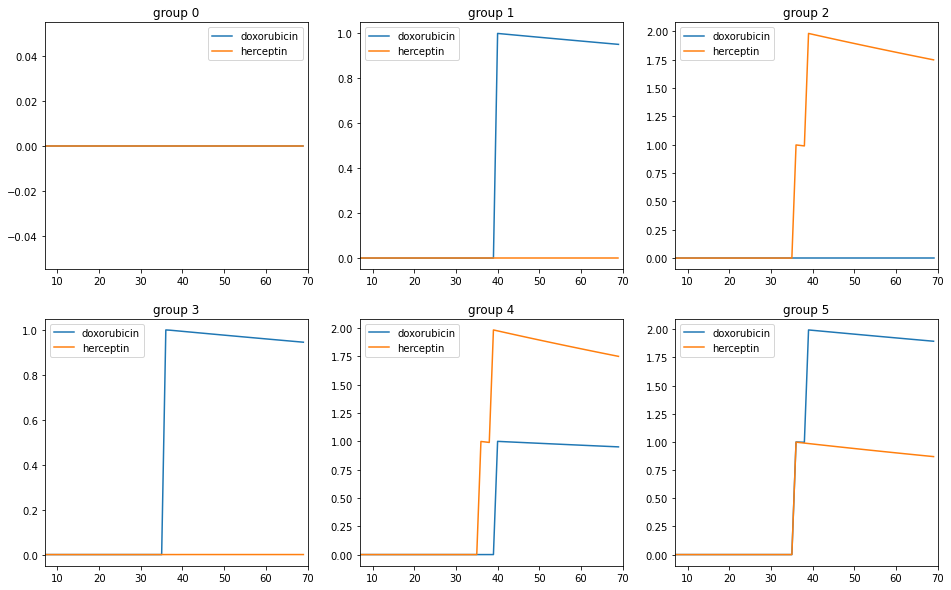

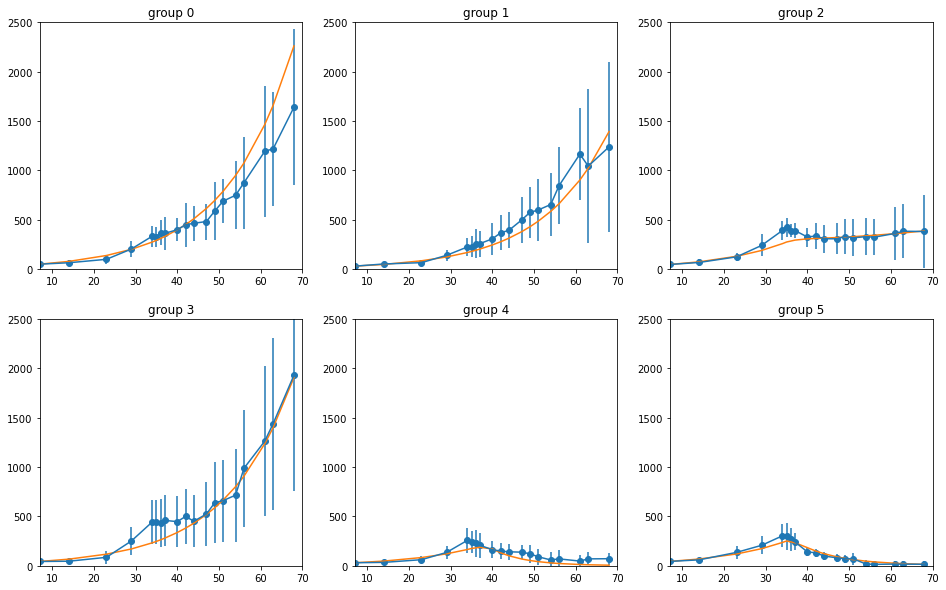

In [7]:
gm1 = growth_model_1()
print(gm1.dose_time_D)
print(gm1.dose_time_H)
r = 6.19e-2
lambda_h = 2.89e-2
lambda_hd = 7.03e-2
tau_d = 1.72e-3
tau_h = 4.17e-3
lambda_dh = 9.78
sim_params = np.array([r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh])
#gm1.set_sim_DH(sim_params)
gm1.rhs(None, sim_params)

print(gm1.sim_D['y'].shape)
print(gm1.sim_H['y'].shape)
print(gm1.sim_D['t'].shape)
print(gm1.sim_H['t'].shape)
dense_times = gm1.sim_D['t']

plt.figure(figsize=(16,10))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.xlim(7,70)
    plt.plot(gm1.sim_D['t'], gm1.sim_D['y'][ii,:])
    plt.plot(gm1.sim_H['t'], gm1.sim_H['y'][ii,:])
    plt.legend(["doxorubicin","herceptin"])
    plt.title("group {}".format(ii))
plt.show()



#sim_times = dense_times
sim_times = days
sim_y = gm1.rhs(sim_times, sim_params)
plt.figure(figsize=(16,10))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.xlim(7,70)
    plt.ylim(0,2500)
    plt.scatter(days, tumor_sizes[ii,:])
    plt.errorbar(days, tumor_sizes[ii,:], tumor_sigmas[ii,:])
    plt.plot(sim_times, sim_y[ii,:])
    plt.title("group {}".format(ii))
    
plt.show()



## Fit backwards model

In [ ]:
growth_model_1().backward()

Only 36 samples in chain.
Sequential sampling (10 chains in 1 job)
CompoundStep
>Metropolis: [lambda_dh]
>Metropolis: [tau_h]
>Metropolis: [tau_d]
>Metropolis: [lambda_hd]
>Metropolis: [lambda_h]
>Metropolis: [r]


Sampling 1 chain for 7 tune and 36 draw iterations (7 + 36 draws total) took 208 seconds.
